## LEVERAGED BUYOUT MODEL 

In [2]:
Input = {'Revenues':3600000,
         'Operating expenses': -2200000,
         'Growth rate':0.09,
         'Stable growth rate': 0.03,
         'Capital expenditures': 125000,
         'Depreciation': -100000,
         'Working capital change': 0.04,
         'Debt': 4500000,
         'Equity': 2000000,
         'Principal repayment': 300000,
         'Risk free rate': 0.045,
         'Market risk premium': 0.055,
         'New debt issued':0,
         'Tax rate': 0.35,
         'Target debt/equity ratio':1.30,
         'Rating':'B',
         'Credit spread':0.065,
         'New debt': 0,
         'Preferred dividends': 0,
         # Accumulate from previous year
         '_WACC': 1,
         '_Cost of equity': 1
         
        }
Input['Change in working capital'] = Input['Revenues']*Input['Working capital change']
initial_beta = 3.7


In [3]:
import pandas as pd 
lbo = pd.DataFrame({'Year 1':Input})
lbo

,Year 1
Capital expenditures,125000
Change in working capital,144000.0
Credit spread,0.065
Debt,4500000
Depreciation,-100000
Equity,2000000
Growth rate,0.09
Market risk premium,0.055
New debt,0
New debt issued,0


In [4]:
def update_financials(curr_year,keep_betaul=True):
    """
    @param curr_year: pandas.Series
    @return updated pandas.Sers
    """
    curr_year = curr_year.copy()
    curr_year['EBIT'] = curr_year[['Revenues','Operating expenses','Depreciation']].sum()
    curr_year['Interest rate'] = curr_year[['Risk free rate','Credit spread']].sum()
    curr_year['Interest'] = -curr_year['Debt']*curr_year['Interest rate']
    curr_year['Tax'] = -curr_year['Tax rate']*curr_year[['EBIT','Interest']].sum()
    curr_year['Net income'] = curr_year[['EBIT','Interest','Tax']].sum()
    curr_year['EBITDA'] = curr_year['EBIT']-curr_year['Depreciation']
    curr_year['FCFF'] = curr_year['EBIT']*(1-curr_year['Tax rate'])-curr_year['Depreciation']-curr_year['Capital expenditures']-curr_year['Change in working capital']
    curr_year['Interest*(1-T)'] = curr_year['Debt'] * curr_year['Interest rate']*(1-curr_year['Tax rate'])
    curr_year['FCFE'] = curr_year['FCFF'] - curr_year['Interest*(1-T)'] - curr_year['Principal repayment'] + curr_year['New debt'] - curr_year['Preferred dividends']
    curr_year['Outstanding debt'] = curr_year['Debt']-curr_year['Principal repayment']+curr_year['New debt']
    curr_year['Outstanding equity'] = curr_year['Equity']+curr_year['Net income']
    curr_year['Total capitalization'] = curr_year['Outstanding debt']+curr_year['Outstanding equity']
    curr_year['D/E ratio'] = curr_year['Outstanding debt']/curr_year['Outstanding equity']
    ul_multiplier = 1+(1-curr_year['Tax rate'])*curr_year['D/E ratio']
    if not keep_betaul: curr_year['BetaUL'] = initial_beta/ul_multiplier
    curr_year['BetaL'] = ul_multiplier*curr_year['BetaUL']
    curr_year['Cost of equity'] = curr_year['Risk free rate']+curr_year['BetaL']*curr_year['Market risk premium']
    curr_year['Cost of debt'] = (curr_year['Risk free rate'] + curr_year['Credit spread'])*(1-curr_year['Tax rate'])
    curr_year['WACC'] = (curr_year['Cost of equity']+curr_year['Cost of debt']*curr_year['Target debt/equity ratio'])/(1+curr_year['Target debt/equity ratio'])
    # Accumulate from previous year
    curr_year['_WACC']*=(1+curr_year['WACC'])
    curr_year['_Cost of equity']*=(1+curr_year['Cost of equity'])
    curr_year['PV FCFF'] = curr_year['FCFF']/curr_year['_WACC']
    curr_year['PV FCFE'] = curr_year['FCFE']/curr_year['_Cost of equity']
    return curr_year
lbo = pd.DataFrame({})
# Calculate BetaUL for the first year, keep for the years to come
lbo['Year 1'] = update_financials(pd.Series(Input),False)
lbo

,Year 1
Revenues,3600000
Operating expenses,-2200000
Growth rate,0.09
Stable growth rate,0.03
Capital expenditures,125000
Depreciation,-100000
Working capital change,0.04
Debt,4500000
Equity,2000000
Principal repayment,300000


In [5]:
# Free Cash Flow
years_to_project = 6

# Changes on year
for i in range(2,years_to_project+1):
    curr_lbo = lbo['Year {0}'.format(i-1)].copy()
    curr_lbo.name = 'Year {0}'.format(i)
    if i == years_to_project:
        curr_lbo['Principal repayment'] = 0
        curr_lbo[['Revenues','Operating expenses',\
                  'Depreciation','Capital expenditures',\
                  'Change in working capital'
                 ]]*=(1+curr_lbo['Stable growth rate'])
    else:
        curr_lbo[['Revenues','Operating expenses',\
                  'Depreciation','Capital expenditures',\
                  'Change in working capital'
                 ]]*=(1+curr_lbo['Growth rate'])
    curr_lbo['Debt'] = curr_lbo['Outstanding debt']
    curr_lbo['Equity'] = curr_lbo['Outstanding equity']
    curr_lbo = update_financials(curr_lbo)
    lbo = pd.concat([lbo,curr_lbo],axis=1)
lbo

# Sum of changes
terminal_year = 'Year {0}'.format(years_to_project)
terminal_FCFF = lbo[terminal_year]['FCFF']/(lbo[terminal_year]['WACC']-lbo[terminal_year]['Growth rate'])
terminal_FCFE = terminal_FCFF - lbo[terminal_year]['Debt']
sum_PVFCFF = lbo.loc['PV FCFF'].sum()
sum_PVFCFE = lbo.loc['PV FCFE'].sum()

print('Free cash flow to Firm: {0}'.format(sum_PVFCFF))
print('Free cash flow to Equity: {0}'.format(sum_PVFCFE))
print('Weighted average cost of capital: {0}'.format(lbo[terminal_year]['WACC']))
print('Terminal value of equity: {0}'.format(terminal_FCFE))
print('Expect selling price after {0} years: {1}'.format(years_to_project, lbo[terminal_year][['Debt','Equity']].sum()))

Free cash flow to Firm: 3222757.2757492745
Free cash flow to Equity: 821095.1909981107
Weighted average cost of capital: 0.11488791076685109
Terminal value of equity: 36491303.73449806
Expect selling price after 6 years: 8662830.465450004


In [6]:
lbo

,Year 1,Year 2,Year 3,Year 4,Year 5,Year 6
Revenues,3600000,3924000.0,4277160.0,4662104.4,5081693.796,5234144.60988
Operating expenses,-2200000,-2398000.0,-2613820.0,-2849063.8,-3105479.542,-3198643.92826
Growth rate,0.09,0.09,0.09,0.09,0.09,0.09
Stable growth rate,0.03,0.03,0.03,0.03,0.03,0.03
Capital expenditures,125000,136250.0,148512.5,161878.625,176447.70125,181741.132288
Depreciation,-100000,-109000.0,-118810.0,-129502.9,-141158.161,-145392.90583
Working capital change,0.04,0.04,0.04,0.04,0.04,0.04
Debt,4500000,4200000,3900000,3600000,3300000,3000000
Equity,2000000,2523250.0,3144000.0,3869094.5,4705994.005,5662830.46545
Principal repayment,300000,300000,300000,300000,300000,0


True

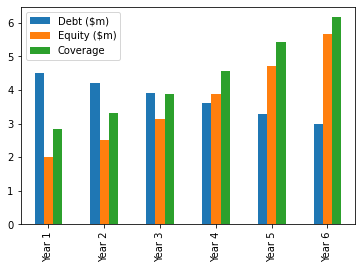

In [10]:
import matplotlib as plt 
# Leverage 
lbo.loc['Coverage'] = lbo.apply(lambda x: -x['EBITDA']/x['Interest'])
lbo.loc['Debt ($m)'] = lbo.loc['Debt']/1000000
lbo.loc['Equity ($m)'] = lbo.loc['Equity']/1000000
lbo.T[['Debt ($m)','Equity ($m)','Coverage']].plot.bar()
plt.is_interactive()

**FREE CASH FLOW ANALYSIS**


True

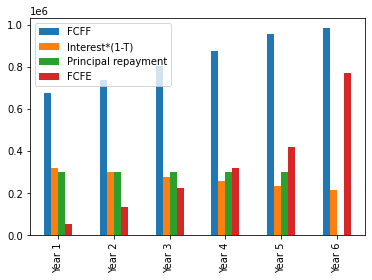

In [11]:
lbo.T[['FCFF','Interest*(1-T)','Principal repayment','FCFE']].plot.bar()
plt.is_interactive()

**Look-up**

In [12]:
is_inrange = lambda low,high,value: low<value and value<high

rating_table = {(-100000,0.5):('D',0.14),
                (0.5,0.8):('C',0.127),
                (0.8,1.25):('CC',0.115),
                (1.25,1.5):('CCC',0.10),
                (1.5,2.0):('B-',0.08),
                (2.0,2.5):('B',0.065),
                (2.5,3.0):('B+',0.048),
                (3.0,3.5):('BB',0.035),
                (3.5,4.0):('BBB',0.023),
                (4.5,6.0):('A-',0.020),
                (6.0,7.5):('A',0.018),
                (7.5,9.5):('A+',0.015),
                (9.5,12.5):('AA',0.010),
                (12.5,100000):('AAA',0.008)
               }
def get_rating_spread(coverage):
    """
    @param coverage: interest coverage ratio
    @return rating and spread
    """
    for low,high in rating_table:
        if is_inrange(low,high,coverage): 
            return rating_table[(low,high)]
get_rating_spread(0.3)

('D', 0.14)